Let’s import the libraries that we are going to use for data manipulation, visualization, training the model, etc.

In [1]:
# import library to ploting
# import matplotlib.ticker as tkr
import matplotlib.pyplot as plt
# import urllib.request
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import pandas as pd
# pd.set_option('display.float_format', lambda x: '%.4f' % x)
%matplotlib inline
import numpy as np
# avoid alert
import warnings
warnings.filterwarnings('ignore')
# import datetime as dt
from scipy import stats
# Import library to preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
# performace metrics libray
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# select the GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1' # SET A SINGLE GPU
# import library modules keras and tensorflow
from keras.layers import *
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU, Dropout, Bidirectional
import matplotlib.image  as mpimg
from keras.models import Model, Input
from keras import regularizers
from keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping

Using TensorFlow backend.


LSTM 

In [2]:
# load the dataset
dataset_throughput = pd.read_csv('../file/dataset_throughput.csv', header=0)

In [3]:
dataset_throughput.set_index('timestamp', inplace=True)
dataset_throughput.sort_values('timestamp', inplace=True)

In [4]:
# swap some columns positions
columnsTitles = ['connect_time','request_ticks','year','month','hour','day','weekday','minute','second','iteration','delta_sys_time','delta_user_time','rate','received','delay','tcp_mean_wind','downthpt']
dataset_throughput = dataset_throughput.reindex(columns=columnsTitles)

Normalization

In [11]:
dataset = dataset_throughput.iloc[:, 8:]
dataset = dataset.astype('float')
print(dataset.shape)
TRAIN_SIZE = int(len(dataset) * 0.60) # 60% train set
VALID_SIZE = int(len(dataset) * 0.80) # 20% valid and test set

(12245155, 9)


In [18]:
onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
second = dataset['second'].values
second = np.reshape(second, (-1,1))
second = onehot_encoder.fit_transform(second)

In [21]:
iteration = dataset['iteration'].values
iteration = np.reshape(iteration, (-1,1))
iteration = onehot_encoder.fit_transform(iteration)

In [25]:
dataset['iteration'] = iteration
dataset['second'] = second

In [28]:
dataset_train = dataset_throughput.iloc[:TRAIN_SIZE, :]
print('Training Set: ', dataset_train.shape)

dataset_val = dataset_throughput.iloc[TRAIN_SIZE:VALID_SIZE, :]
print('Validation Set: ', dataset_val.shape)

dataset_test = dataset_throughput.iloc[VALID_SIZE:, :]
print('Test Set: ', dataset_test.shape)

Training Set:  (7347093, 17)
Validation Set:  (2449031, 17)
Test Set:  (2449031, 17)


Scaling the Data

In [30]:
# normalization with downthpt!
f_columns = ['second', 'iteration', 'delta_sys_time','delta_user_time','rate','received','delay','tcp_mean_wind','downthpt']

f_transformer = RobustScaler()
thrput_transformer = RobustScaler()

f_transformer = f_transformer.fit(dataset_train[f_columns].to_numpy())
thrput_transformer = thrput_transformer.fit(dataset_train[['downthpt']])

dataset_train.loc[:, f_columns] = f_transformer.transform(dataset_train[f_columns].to_numpy())
dataset_train['downthpt'] = thrput_transformer.transform(dataset_train[['downthpt']])

dataset_val.loc[:, f_columns] = f_transformer.transform(dataset_val[f_columns].to_numpy())
dataset_val['downthpt'] = thrput_transformer.transform(dataset_val[['downthpt']])

dataset_test.loc[:, f_columns] = f_transformer.transform(dataset_test[f_columns].to_numpy())
dataset_test['downthpt'] = thrput_transformer.transform(dataset_test[['downthpt']])

In [31]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [32]:
time_steps = 11
# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(dataset_train, dataset_train.downthpt, time_steps)
X_test, y_test = create_dataset(dataset_val, dataset_val.downthpt, time_steps)
X_val, y_val = create_dataset(dataset_test, dataset_test.downthpt, time_steps)

In [33]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(7347082, 11, 17) (7347082,) (2449020, 11, 17) (2449020,)


### Modeling my LSTM with API Keras

Bidirectional

In [47]:
import keras
from keras import optimizers

def model_lstm():
    input_x = Input(shape=(X_train.shape[1], X_train.shape[2]))
    x = Bidirectional(LSTM(units=32, return_sequences=True))(input_x)
    x = Bidirectional(LSTM(units=16, activation ='relu'))(x)
    x = Dropout(rate=0.2)(x)
    x = Dense(units=1, activation='linear')(x)
    model = Model(inputs=input_x, outputs=x)
    return model

In [48]:
def compile_fit():
    model = model_lstm()
    model.summary()
    sgd = optimizers.SGD(lr=0.01, decay=1e-5, momentum=0.9)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
    history = model.fit(X_train, y_train, 
                        epochs=20, 
                        batch_size=11, 
                        validation_data=(X_test, y_test), 
                        shuffle=False)
    return history, model

In [49]:
hist, model = compile_fit()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 11, 17)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 11, 64)            12800     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 32)                10368     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 23,201
Trainable params: 23,201
Non-trainable params: 0
_________________________________________________________________

Train on 7347082 samples, validate on 2449020 samples
Epoch 1/20
7347082/7347082 [==============================] - 3910

In [53]:
y_pred = model.predict(X_val)

In [54]:
y_train_inv = thrput_transformer.inverse_transform(y_train.reshape(1, -1))

In [58]:
y_val_inv = thrput_transformer.inverse_transform(y_val.reshape(1, -1))

In [60]:
y_pred_inv = thrput_transformer.inverse_transform(y_pred)

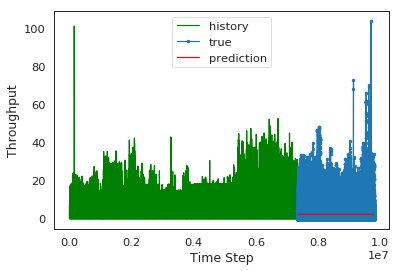

In [65]:
def plot_prediction(y_train, y_train_inv, y_val, y_val_inv):
    plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
    plt.plot(np.arange(len(y_train), len(y_train) + len(y_val)), y_val_inv.flatten(), marker='.', label="true")
    plt.plot(np.arange(len(y_train), len(y_train) + len(y_val)), y_pred_inv.flatten(), 'r', label="prediction")
    plt.ylabel('Throughput')
    plt.xlabel('Time Step')
    plt.legend()
    plt.savefig(os.path.join('./plots', 'prediction.eps'))
    plt.show();
plot_prediction(y_train, y_train_inv, y_val, y_val_inv)

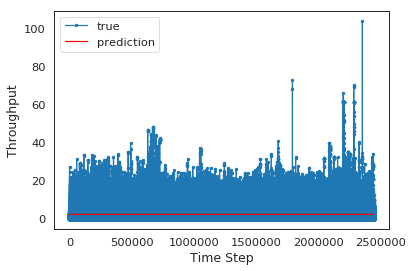

In [68]:
def plot_prediction_(y_pred_inv, y_val_inv):
    plt.plot(y_val_inv.flatten(), marker='.', label="true")
    plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
    plt.ylabel('Throughput')
    plt.xlabel('Time Step')
    plt.legend()
    plt.savefig(os.path.join('./plots', 'prediction_detail.eps'))
    plt.show();
plot_prediction_(y_pred_inv, y_val_inv)

In [40]:
# plot da perda do modelo

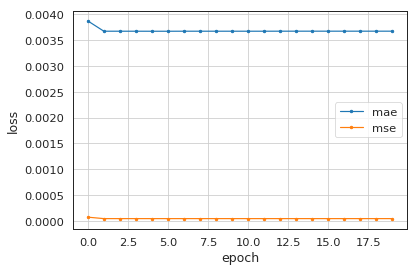

In [51]:
def plot_history_metrics(history):
    # plot metrics
    plt.plot(history.history['mae'], marker='.')
    plt.plot(history.history['mse'], marker='.')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.grid()
    plt.legend(['mae', 'mse'], loc='best')
    # plt.savefig(os.path.join('./plots', 'mse.eps'))
    plt.show()
    
plot_history_metrics(hist)

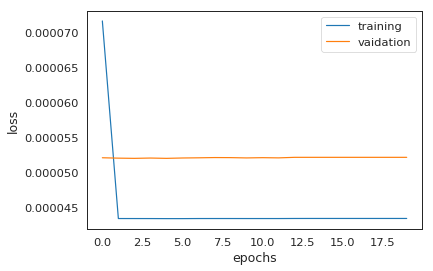

In [52]:
def plot_history_loss(history):
    #-----------------------------------------------------------
    # Retrieve a list of list results on training and test data
    # sets for each training epoch
    #-----------------------------------------------------------
    # loss=history.history['loss']
    # val_loss=history.history['val_loss']
    # epochs=range(len(loss)) # Get number of epochs
    
    plt.plot(history.history['loss'], label='training')
    plt.plot(history.history['val_loss'], label='vaidation')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend();
    # plt.savefig(os.path.join('./plots', 'loss.eps'))

    #------------------------------------------------
    # Plot training and validation loss per epoch
    #------------------------------------------------
    # plt.plot(epochs, loss, val_loss)
    # plt.title('Training loss')
    # plt.xlabel("Epochs")
    # plt.ylabel("Loss")
    # plt.legend(["Loss"])
    
plot_history_loss(hist)